In [65]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os
import matplotlib.pyplot as plt
color = sns.color_palette()
%matplotlib inline
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt


In [66]:
train = pd.DataFrame(pd.read_csv('C:/Users/Лавандос/Downloads/train-balanced-sarcasm.csv/train-balanced-sarcasm.csv'))
test = pd.DataFrame(pd.read_csv('C:/Users/Лавандос/Downloads/test-balanced.csv'))

In [67]:
train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [69]:
test.head(100)

,7x7dx,c07nkao c07nk63,1 0
0,7xtxk,c07pji4 c07ppds,1 0
1,7zh5l,c07twag c07twp2,1 0
2,80nmo,c07y1rj c07xhyn,0 1
3,8139p,c07yhlm c07yoiw,1 0
4,bnmod,c0nnujf c0nofrs,1 0
...,...,...,...
95,yn31k,c5xkqg3 c5x63l3,0 1
96,ypwwg,c5xsewy c5xts6b,0 1
97,ypfyb,c5xnxjk c5xnfh2,1 0
98,ypah4,c5xwl0d c5xs4z0,0 1


Можно увидеть, что число непустых значений не соответствует числу комментариев, поэтому удалим соответствующие строки в обучающем датасете

In [70]:
train.dropna(subset=['comment'], inplace=True)

Можно увидеть, что количество саркастических и не саркастических комментариев практически равны, что готоворит о том, что наш датасет сбалансирован

In [71]:
train['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

# Task№1 Графический анализ данных

Посмотрим на графики нашего таргета и убедимся наверняка, что датасет сбалансирован

In [72]:
cnt_srs = train['label'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

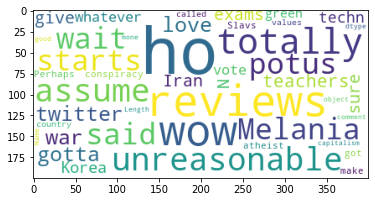

In [73]:
wordcloud = WordCloud(max_font_size=None, background_color='white').generate(str(train.loc[train['label'] == 1, 'comment']))
plt.imshow(wordcloud)

Используя WordCloud мы можем увидеть слова, которые чаще всего встречаются в саркастических комментариях. Сделаем аналогично для несаркастических

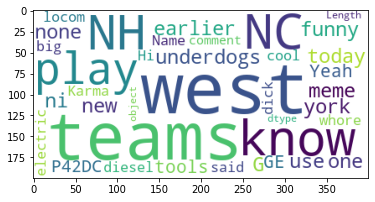

In [74]:
wordcloud = WordCloud(max_font_size=None, background_color='white').generate(str(train.loc[train['label'] == 0, 'comment']))
plt.imshow(wordcloud)

Теперь посмотрим на кол-во символов в саркастических/несаркастических комментариях

<AxesSubplot:>

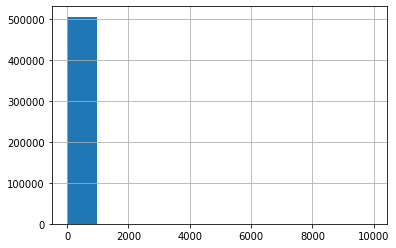

In [75]:
train.loc[train['label'] == 1, 'comment'].str.len().hist()

<AxesSubplot:>

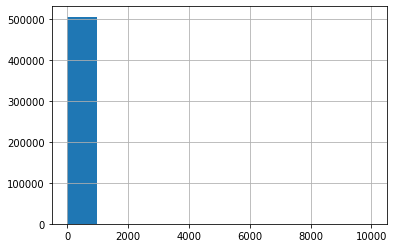

In [76]:
train.loc[train['label'] == 0, 'comment'].str.len().hist()

Видно, что распределение в текущем виде, не даст ничего нам узнать, поэтому прологарифмируем

<AxesSubplot:>

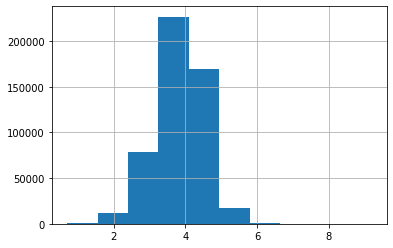

In [77]:
train.loc[train['label'] == 1, 'comment'].str.len().apply(np.log1p).hist()

<AxesSubplot:>

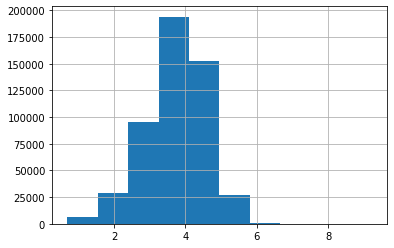

In [78]:
train.loc[train['label'] == 0, 'comment'].str.len().apply(np.log1p).hist()

В принципе несаркастические комментарии немного отличаются от саркастических по длине

Теперь посмотрим какие слова наиболее чаще встречаемые в тех или иных комментариях

In [79]:
from collections import defaultdict
train1_df = train[train["label"]==1]
train0_df = train[train["label"]==0]

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

freq_dict = defaultdict(int)
for sent in train1_df["comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of non sarcrastic comments", 
                                          "Frequent words of sarcrastic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

C:\Users\Лавандос\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



посмотрим на количество Биграмм

In [81]:
freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["comment"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of non sarcastic comments", 
                                          "Frequent bigrams of sarcastic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

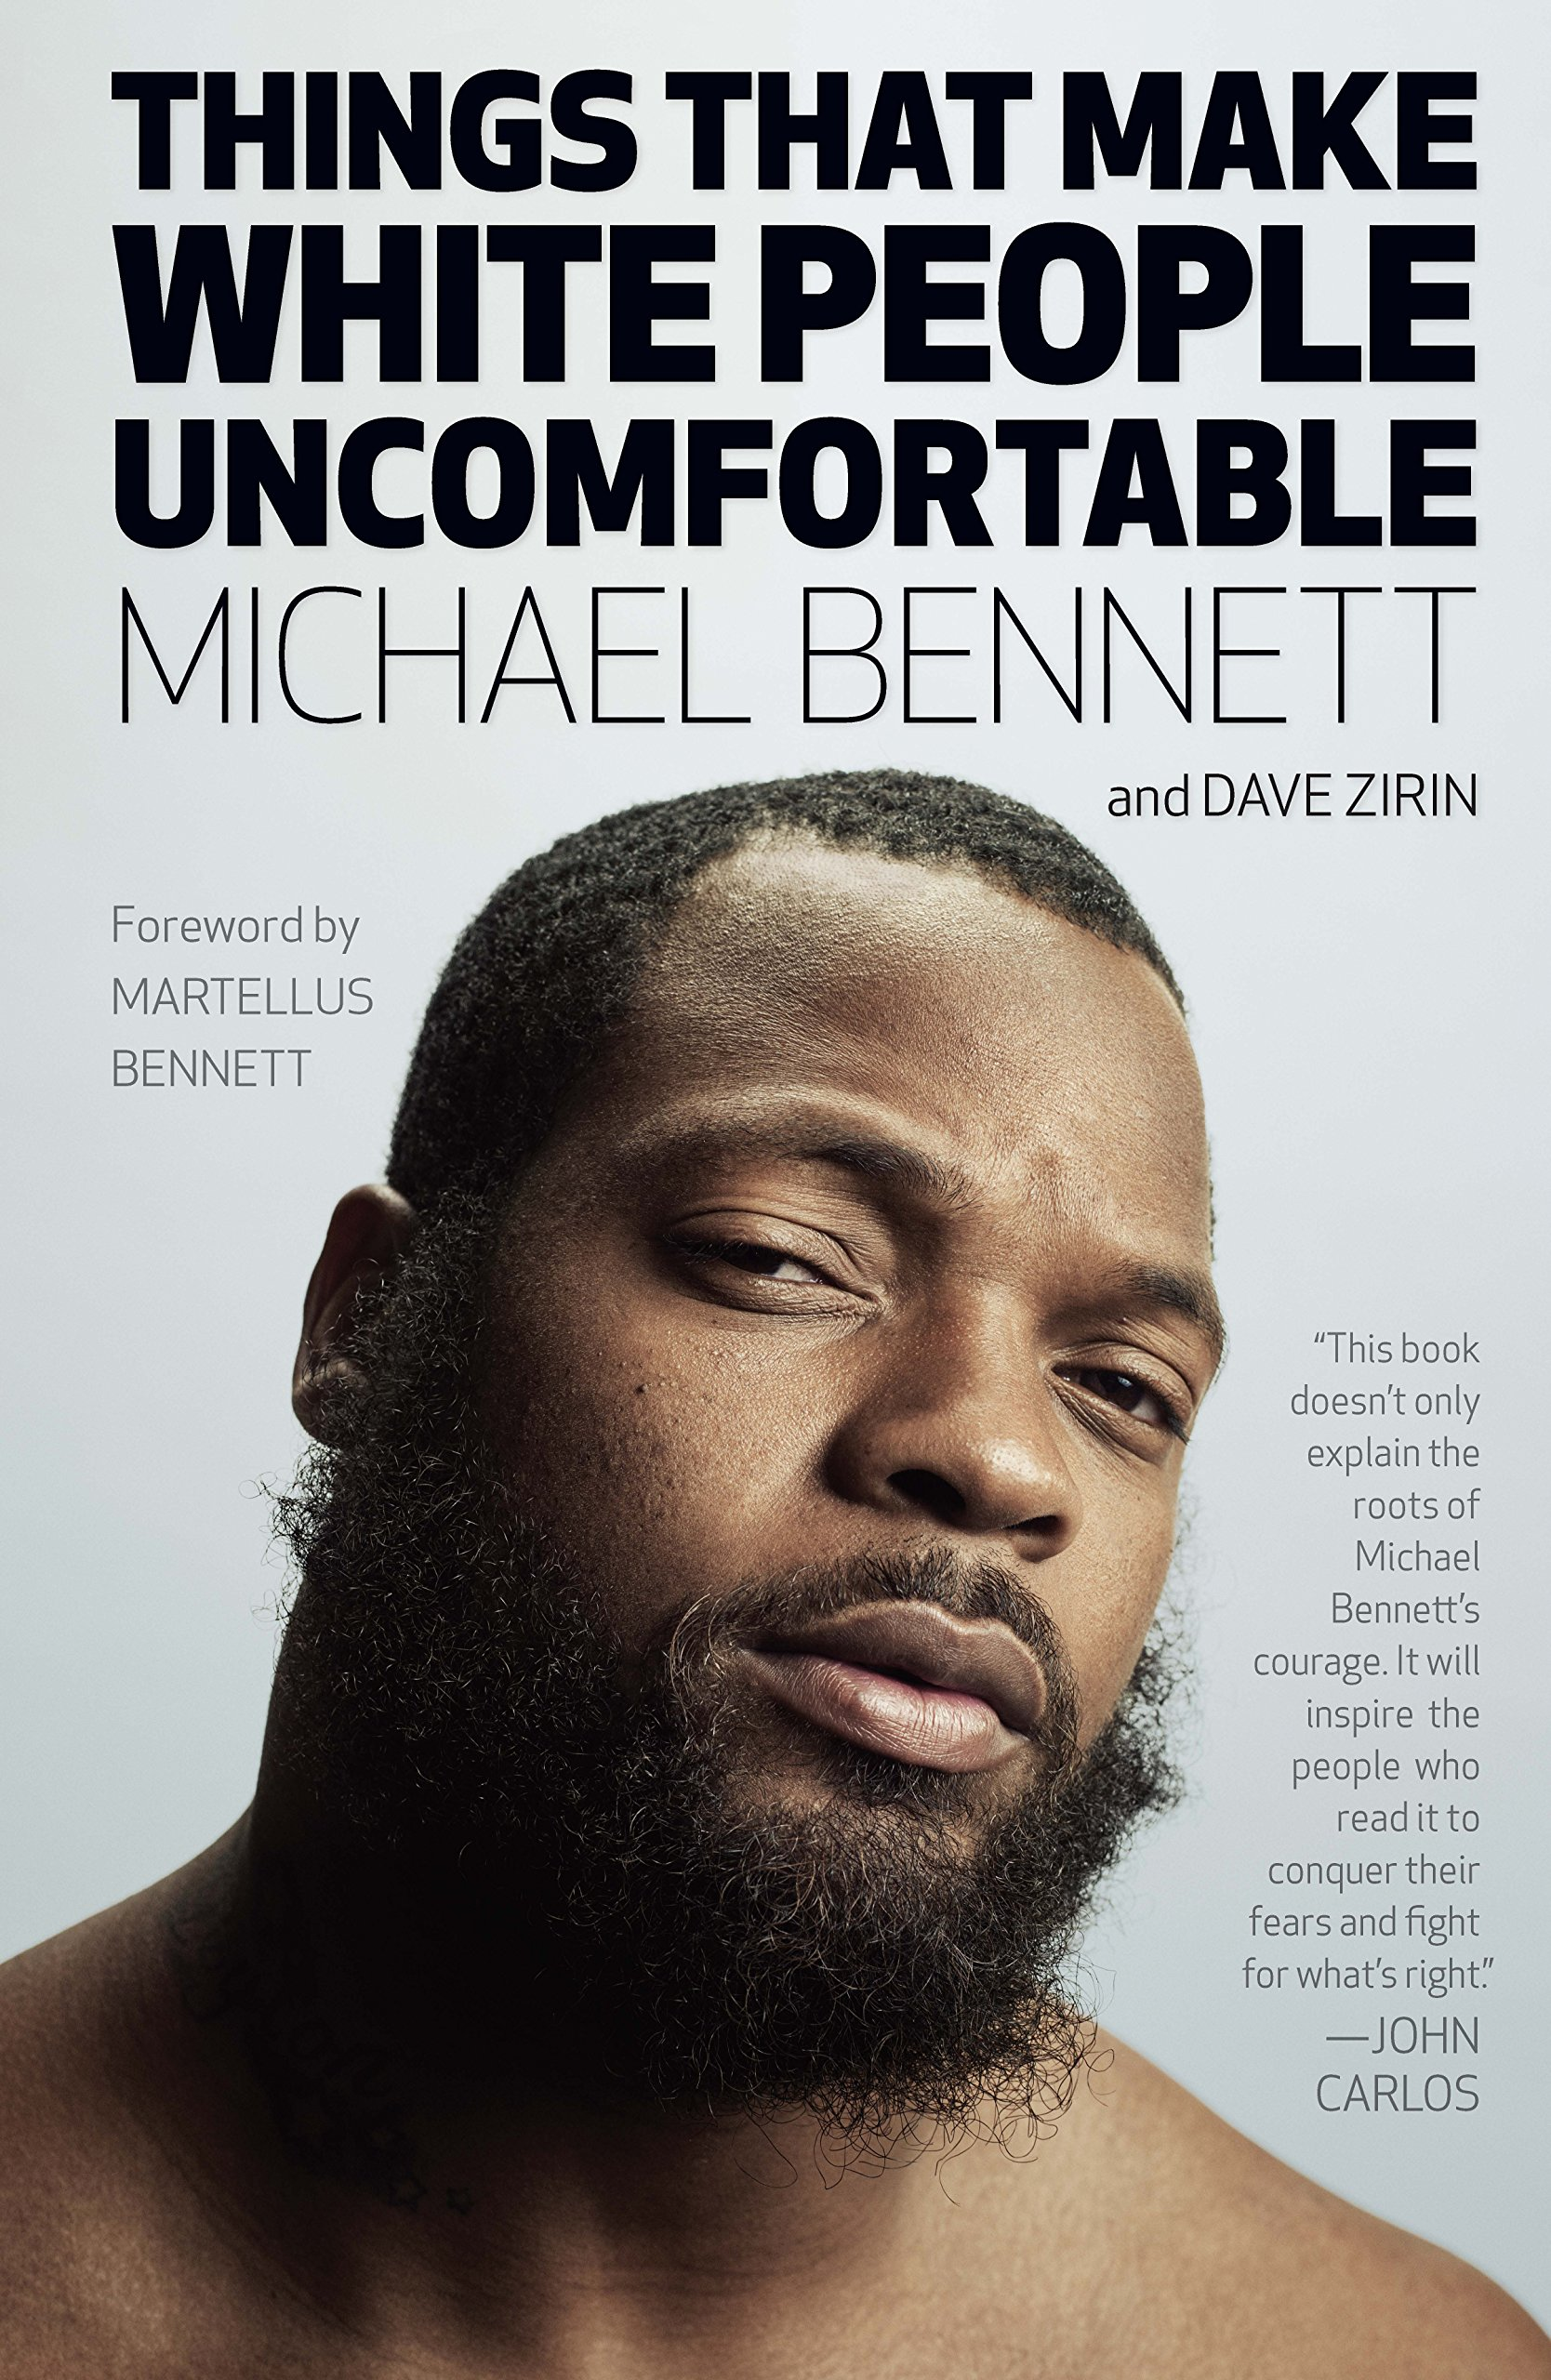

In [82]:
from IPython.display import Image
#очень много "белых" людей, если загуглить white people
Image(filename='white_people.jpg', width=320, height=480)

Посмотрим на Триграммы соотв.

In [89]:
freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["comment"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of non-sarcastic comments", 
                                          "Frequent trigrams of sarcastic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

C:\Users\Лавандос\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Task№2. Построение TF-Idf + создание Pipeline для Логистической регрессии, основанной на 'comment'

Засплитим данные для обучения

In [84]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train['comment'], train['label'], random_state=17)

Переходим к обучению модели

In [85]:
#создаём TF-Idf для которого определим использование биграм и юниграм, количество фичей(макс.)
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# определяем логическую регрессию с регуляризацией по дефолту, verbose - любое положительное число, т.к solver = lbfgs,
#  max_iter = 7600, т.к работа с данными, кроме как удаление пропущенных комментариев не проводилась, поэтому нужно увеличить количество итераций для успешного обучения
logit = LogisticRegression(solver='lbfgs',
                           random_state=17, verbose=1, max_iter= 7600)
#обычный Pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [86]:
#помещаем для обучения
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.3s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(max_iter=7600, random_state=17,
                                    verbose=1))])

In [87]:
#предсказываем и выводим оценку
valid_pred = tfidf_logit_pipeline.predict(valid_texts)
accuracy_score(y_valid, valid_pred)

0.7212438759923069

# Task№3. Посмотреть на веса слов с помощью eli5

In [88]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'], top = 10)

C:\Users\Лавандос\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Weight?,Feature
+8.968,yes because
+7.494,obviously
+7.442,clearly
+7.118,yeah because
+6.769,totally
+6.189,because
+5.884,how dare
+5.395,right because
+5.171,good thing
+5.036,duh
